# Test JulES

### Import packages

In [1]:
# using Pkg; Pkg.status()
# Pkg.add("CSV"); Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables")
# Pkg.precompile()
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables
plotlyjs(); # uncomment for interactive plots

In [3]:
# config = YAML.load_file(joinpath("data", "config_jules_la.yml")) # config without datasets
config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_la_demo.yml")) # config with NVE datasets
scenarioyear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1];

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 31


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    settings = config[config["main"]["settings"]]

    sti_thema = joinpath(config["main"]["inputpath"], "datasett", "data_fra_thema")
    sti_vannkraft = joinpath(config["main"]["inputpath"], "datasett", "data_fra_dynmodell")

    tsd = JSON.parsefile(joinpath(sti_thema, "dataset_thema.json"))
    themastructure = JulES.getelements(tsd, sti_thema)
    tst = JSON.parsefile(joinpath(sti_thema, "dataset_thema_excl_hydro_nose.json"))
    themastructure_exl = JulES.getelements(tst, sti_thema)
    tse = JSON.parsefile(joinpath(sti_thema, "tidsserier_thema.json"))
    themaseries = JulES.getelements(tse, sti_thema)

    dse = JSON.parsefile(joinpath(sti_vannkraft, "tidsserier_detd.json"))
    detdseries = JulES.getelements(dse)
    dst = JSON.parsefile(joinpath(sti_vannkraft, "dataset_detd.json"))
    detdstructure = JulES.getelements(dst)

    progelements = vcat(themaseries, themastructure)
    
    if JulES.getonlyagghydro(settings)
        global detailedrescopl = Dict()
        return Dict("elements" => progelements, "detailedrescopl" => detailedrescopl)
    else
        global elements = vcat(themaseries, themastructure_exl, detdseries, detdstructure)
        global detailedrescopl = JSON.parsefile(joinpath(sti_vannkraft, "magasin_elspot.json"))
        return Dict("elements" => elements, "progelements" => progelements, "detailedrescopl" => detailedrescopl)
    end
end

dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 3 entries:
  "progelements"    => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Hou…
  "elements"        => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Hou…
  "detailedrescopl" => Dict{String, Any}("49925"=>"NO3", "62801"=>"NO4", "16655…

In [8]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.028132 seconds (1.38 k allocations: 90.907 KiB, 99.28% compilation time)
Get data
  0.001341 seconds (20 allocations: 1.281 KiB)
Make dummy objects


  6.613988 seconds (11.26 M allocations: 2.055 GiB, 13.64% gc time, 45.84% compilation time)
Init scenario modelling for simulation, prognosis and stochastic


  3.600943 seconds (2.54 M allocations: 66.514 MiB, 93.73% compilation time)
  3.643465 seconds (2.54 M allocations: 66.882 MiB, 93.79% compilation time)
Init prognosis

 63.665052 seconds (4.64 M allocations: 215.042 MiB, 1.57% compilation time)

 68.804093 seconds (7.41 M allocations: 436.591 MiB, 0.25% gc time, 6.25% compilation time: <1% of which was recompilation)
Mapping between aggregated and detailed storages


 16.890746 seconds (825.24 k allocations: 89.745 MiB, 3.72% compilation time)
Init stochastic


  3.765148 seconds (10.06 M allocations: 458.110 MiB, 3.13% gc time, 36.22% compilation time)


  2.801839 seconds (9.66 M allocations: 436.424 MiB, 7.05% gc time, 7.92% compilation time)

  9.088139 seconds (2.28 M allocations: 68.194 MiB, 2.50% compilation time)


  1.722414 seconds (1.78 M allocations: 236.674 MiB, 47.07% compilation time)
 23.073121 seconds (29.49 M allocations: 2.298 GiB, 3.59% gc time, 22.37% compilation time)


Init clearing


  0.523044 seconds (326.16 k allocations: 97.652 MiB, 42.25% compilation time)

  0.538227 seconds (277.53 k allocations: 16.007 MiB, 65.45% compilation time)


  9.047796 seconds (10.66 M allocations: 1.963 GiB, 10.77% gc time, 35.44% compilation time)


 10.534240 seconds (11.46 M allocations: 2.086 GiB, 9.25% gc time, 39.72% compilation time)
Init results


  2.347331 seconds (1.42 M allocations: 91.829 MiB, 90.89% compilation time)


Simulate forward
FixedDataTwoTime(

DateTime("2024-12-30T00:00:00"), DateTime("1980-12-31T00:00:00"))


  0.226191 seconds (1.99 M allocations: 36.633 MiB)


  3.984144 seconds (262.69 k allocations: 15.415 MiB, 2.58% compilation time)


  2.583753 seconds (2.27 M allocations: 67.734 MiB, 4.90% compilation time)


  3.005568 seconds (632.55 k allocations: 32.656 MiB, 2.36% compilation time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-02T00:00:00"))


  2.389769 seconds (138.21 k allocations: 7.006 MiB)


  0.727624 seconds (2.09 M allocations: 55.541 MiB)


  3.389289 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-04T00:00:00"))


  2.392804 seconds (138.28 k allocations: 7.011 MiB)


  0.885724 seconds (2.09 M allocations: 55.538 MiB)


  3.434375 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-06T00:00:00"))


  3.396679 seconds (138.19 k allocations: 7.006 MiB)


  1.653010 seconds (2.09 M allocations: 55.538 MiB)


  2.550608 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-08T00:00:00"))


  0.246743 seconds (1.99 M allocations: 36.634 MiB)


  2.014542 seconds (138.34 k allocations: 7.016 MiB)


  0.712269 seconds (2.09 M allocations: 55.537 MiB)


  2.329266 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-10T00:00:00"))


  2.092496 seconds (138.20 k allocations: 7.004 MiB)


  0.689797 seconds (2.09 M allocations: 55.540 MiB)


  2.529335 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-12T00:00:00"))


  2.351260 seconds (138.21 k allocations: 7.006 MiB)


  0.721511 seconds (2.09 M allocations: 55.538 MiB)


  2.680975 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-14T00:00:00"))


  3.528461 seconds (138.19 k allocations: 7.007 MiB)


  1.575317 seconds (2.10 M allocations: 55.887 MiB, 18.77% gc time)


  3.272306 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-16T00:00:00"))


  0.231500 seconds (1.99 M allocations: 36.634 MiB)


  2.744346 seconds (138.23 k allocations: 7.006 MiB)


  0.766072 seconds (2.09 M allocations: 55.538 MiB)


  3.105247 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-18T00:00:00"))


  2.814263 seconds (138.23 k allocations: 7.005 MiB)


  0.704991 seconds (2.09 M allocations: 55.538 MiB)


  2.413698 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-20T00:00:00"))


  2.575359 seconds (138.21 k allocations: 7.005 MiB)


  0.700824 seconds (2.09 M allocations: 55.541 MiB)

  2.396765 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-22T00:00:00"))


  3.775148 seconds (138.20 k allocations: 7.004 MiB)


  1.559613 seconds (2.09 M allocations: 55.538 MiB)


  2.351306 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-24T00:00:00"))


  0.248964 seconds (1.99 M allocations: 36.635 MiB)


  2.771596 seconds (138.22 k allocations: 7.004 MiB)


  0.709830 seconds (2.09 M allocations: 55.538 MiB)


  2.651899 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-26T00:00:00"))


  2.221871 seconds (138.24 k allocations: 7.008 MiB)


  0.705520 seconds (2.09 M allocations: 55.537 MiB)


  2.469946 seconds (621.18 k allocations: 31.885 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-28T00:00:00"))


  2.051867 seconds (138.24 k allocations: 7.008 MiB)


  0.732124 seconds (2.09 M allocations: 55.537 MiB)


  2.758632 seconds (621.18 k allocations: 31.885 MiB)
The simulation took: 1.8521345083333334 minutes
Time usage per timestep: 6.94550440625 seconds
Handle output

Row,model,update,solve,other,total
,String,Float64,Float64,Float64,Float64
1,long,0.170309,0.1186,0.0013517,0.290261
2,med,0.271657,0.18063,0.0890589,0.541346
3,short,0.202979,1.98801,0.0388861,2.22988
4,clearing,0.0521148,2.62002,0.0813494,2.75349


Row,umaster,usub,conv,count,smaster,ssub,hlmaster,wwres,total,short,core
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Int64
1,0.00027312,0.0210762,0.307741,1.6,0.00180973,0.304638,2.69333e-6,0.000187467,0.370939,false,12
2,0.000346347,0.0318676,0.276673,1.6,0.00197381,0.273088,3.62667e-6,0.00018584,0.35585,false,17
3,0.000340053,0.029681,0.26943,1.6,0.00228269,0.265584,2.56e-6,0.000222533,0.34116,false,11
4,0.000295867,0.0280943,0.231504,1.6,0.00163272,0.228644,3.6e-6,0.000173867,0.300272,false,16
5,0.00013526,0.0190363,0.242877,0.4,0.00094178,0.241322,5.73333e-7,7.68867e-5,0.271188,true,4
6,0.000225387,0.0204661,0.235211,0.4,0.00142139,0.233173,6.46667e-7,7.47667e-5,0.265223,true,2
7,0.0003332,0.0270573,0.191147,1.33333,0.00179485,0.18829,2.8e-6,0.00013296,0.264959,false,13
8,0.000312853,0.0221346,0.181635,1.6,0.00186979,0.178502,2.10667e-6,0.000139867,0.241277,false,10
9,0.000173487,0.0152618,0.214498,0.4,0.00115247,0.212689,5.4e-7,7.796e-5,0.238951,true,3


Row,core,umaster_sum,usub_sum,conv_sum,count_sum,smaster_sum,ssub_sum,hlmaster_sum,wwres_sum,total_sum
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,12,0.00241136,0.0768949,0.45524,26.9333,0.0135923,0.428073,5.84533e-5,0.00065728,0.649319
2,11,0.00255621,0.0908786,0.418782,29.6,0.0164462,0.388162,6.2e-5,0.000732693,0.637931
3,17,0.0245322,0.0801491,0.411481,25.8667,0.0138876,0.385869,6.0e-5,0.00059992,0.620012
4,16,0.00239565,0.0784828,0.360791,29.0667,0.0159317,0.332562,6.584e-5,0.000622213,0.556713
5,13,0.00250845,0.0790057,0.33094,29.8667,0.0169415,0.299386,7.02133e-5,0.00059832,0.533765
6,10,0.00239107,0.0721432,0.331634,31.4667,0.0172853,0.298776,6.05067e-5,0.000578933,0.515845
7,14,0.00240765,0.0786394,0.308303,28.0,0.0151802,0.280719,5.84533e-5,0.000557227,0.500659
8,15,0.00247859,0.102686,0.286977,27.4667,0.0144952,0.260659,6.69067e-5,0.000598533,0.493971
9,20,0.00196536,0.0704889,0.288537,22.9333,0.0121859,0.265313,5.00533e-5,0.000541467,0.458928


9-element Vector{Float64}:
  0.0030435826666666667
  0.0572789028888889
  0.240336392
 18.975555555555555
  0.009954540888888887
  0.22108646533333337
  4.189555555555556e-5
  0.0004216808888888889
  0.3874604635555555

 20.501873 seconds (12.00 M allocations: 865.045 MiB, 1.22% gc time, 57.55% compilation time: 6% of which was recompilation)

Dict{Any, Any} with 27 entries:
  "svindex"            => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "demandbalancenames" => SubString{String}["NO2", "NO2", "NO2", "NO2", "NO2", …
  "skipfactor"         => 4.0
  "stochastictimes"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … …
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "areanames"          => ["NO2"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "batmatrix"          => [0.0795 0.0 0.0585; 0.159 0.0 0.117; … ; 0.159 0.0 0.…
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [1.615 14.1 … 0.75 54.5617; 1.615 14.1 … 0.75 58.0875…
  "statenames"         => ["Reservoir_2801", "Reservoir_26609_max", "Reservoir_…
  "resnames"           => ["Reservoir_7402", "Reservoir_7853", "Reservoir_14603…
  "shorts"             => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, …
  "demandvalu

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"]
shorts = data["shorts"]
skipfactor = data["skipfactor"];

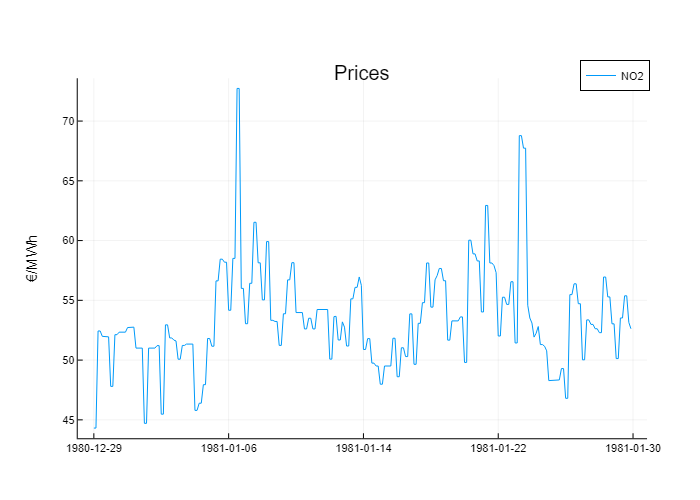

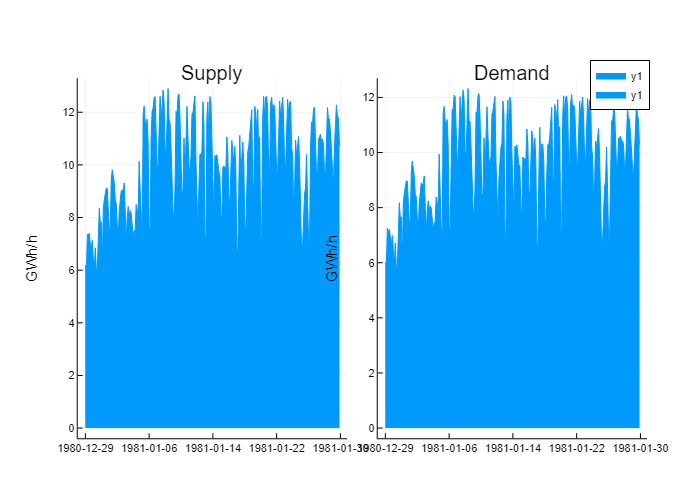

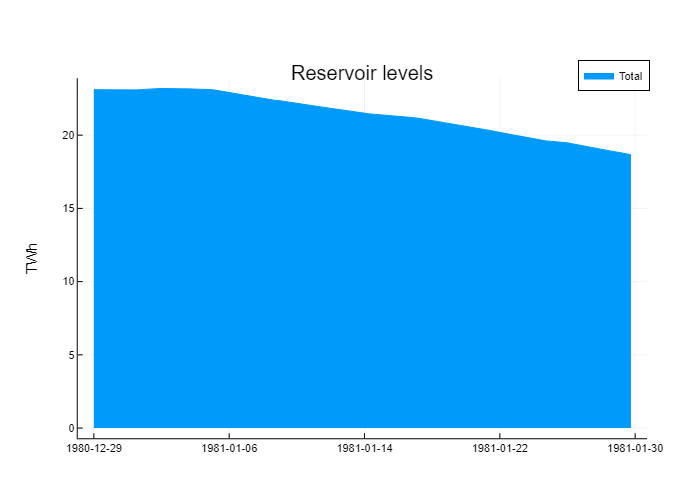

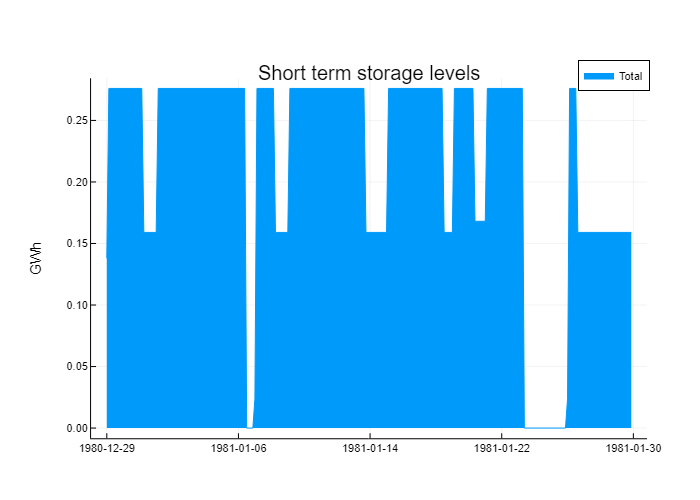

┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
├───────────────────────────────────┼───────────────────────────────────┤
│                           87.3812 │                           84.6965 │
└───────────────────────────────────┴───────────────────────────────────┘


In [10]:
# Plot prices
idxwohub = findall(x -> !occursin("HUB", x), powerbalancenames) # remove hubs, not active in 2025 dataset
display(plot(x1, prices[:,idxwohub]*100, labels=reshape(powerbalancenames[idxwohub],1,length(powerbalancenames[idxwohub])), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
# maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
# supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
# demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
sumsupplyvalues = sum(supplyvalues,dims=2)
sumdemandvalues = sum(demandvalues,dims=2)
maxdemsup = isempty(sumsupplyvalues) ? maximum(sumdemandvalues) : (isempty(sumdemandvalues) ? maximum(sumsupplyvalues) : max(maximum(sumdemandvalues), maximum(sumsupplyvalues)))
supplychart = areaplot(x1,sumsupplyvalues,title="Supply", ylabel = "GWh/h")
demandchart = areaplot(x1,sumdemandvalues,title="Demand", ylabel = "GWh/h")
display(plot([supplychart,demandchart]...,layout=(1,2),size=(800,500)))

# Plot storages
# display(areaplot(x2, hydrolevels,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total",size=(800,500),title="Reservoir levels", ylabel = "TWh")) #

display(areaplot(x1, dropdims(sum(batterylevels,dims=2),dims=2),labels="Total",size=(800,500),title="Short term storage levels", ylabel = "GWh")) #

# Plot list of yearly mean production and demand for each supply/demand TODO: split demand/supply and transmission
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
# show(joineddf,allcols=true, allrows=true, nosubheader = true)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader = false)

# # Plot list of yearly income and cost for each supply/demand (only works if exogenprices are collected)
# supplyrev = copy(supplyvalues)
# for (i,supplybalancename) in enumerate(supplybalancenames)
#     idx = findfirst(isequal(supplybalancename), powerbalancenames)
#     supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
# end
# demandrev = copy(demandvalues)
# for (i,demandbalancename) in enumerate(demandbalancenames)
#     idx = findfirst(isequal(demandbalancename), powerbalancenames)
#     demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
# end
# meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
# meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
# supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
# demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
# supplyrevdf[!,:ID] = collect(1:length(supplynames))
# demandrevdf[!,:ID] = collect(1:length(demandnames))
# joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
# # pretty_table(joinedrevdf,show_subheader = false)

# # Sum revenues and cost
# pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader = false)

# # Plot storagevalues for each reservoir and scenarios
# maxlongtermstorages = 10
# maxshorttermstorages = 10
# shortindex = x3
# medindex = x3[1:Int(skipfactor):Int(end-skipfactor)]
# numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
# numscen = length(scenarionames) - numop
# j = 0
# k = 0
# for (i, storagename) in enumerate(storagenames)
#     if shorts[i]
#         j += 1
#         j > maxshorttermstorages && continue
#         storagevalues_ = storagevalues[:,:,:]
#         index = shortindex
#     else
#         k += 1
#         k > maxlongtermstorages && continue
#         storagevalues_ = storagevalues[1:Int(skipfactor):Int(end-skipfactor),:,:]
#         index = medindex
#     end
#     p = plot(index, storagevalues_[:,1:numscen,i] * -100, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
#     plot!(p, index, storagevalues_[:,numscen+1:end,i] * -100, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
#     display(p)
# end